In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [2]:
%run utils.py

In [3]:
%run dataset.py
%run config.py
%run __init__.py
%run grad_cam.py

In [32]:
train_dataset = PneumoniaDetectionDataset(split="train")
val_dataset = PneumoniaDetectionDataset(split="val")
test_dataset = PneumoniaDetectionDataset(split="test", normalize=True)

In [5]:
classes = train_dataset.dataset.classes

In [6]:
sample_data = None
for data in test_dataset:
    sample_data = data
    break

In [7]:
sample_image, sample_label, _ = sample_data

In [33]:
test_dataset = torch.utils.data.Subset(test_dataset, range(8))

In [42]:
eval_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=True,
    # num_workers=2,
    # pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    # num_workers=2,
    # pin_memory=True
)

In [10]:
pretrained_path = "trained/adam-0.0001-64-3-augment/epoch_2/"
model = torch.load(f"{pretrained_path}model.pth", weights_only=False)

In [11]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [52]:
input_tensor = sample_image.unsqueeze(0)
targets = [ClassifierOutputTarget(0)]

In [ ]:
# with GradCAM(model=model, target_layers=[model.model[0].model.layer4[-1]]) as cam:
#   # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#   grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
#   # In this example grayscale_cam has only one image in the batch:
#   grayscale_cam = grayscale_cam[0, :]
#   visualization = show_cam_on_image(image.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
#   # You can also get the model outputs without having to redo inference
#   model_outputs = cam.outputs

In [53]:
for param in model.parameters():
    param.requires_grad = True

In [54]:
cam = GradCAM(model=model, target_layers=[model.model[0].model.layer4[-1]])
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(sample_image.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)

In [55]:
outputs = cam.outputs

In [56]:
torch.argmax(outputs, dim=1)[0]

tensor(0)

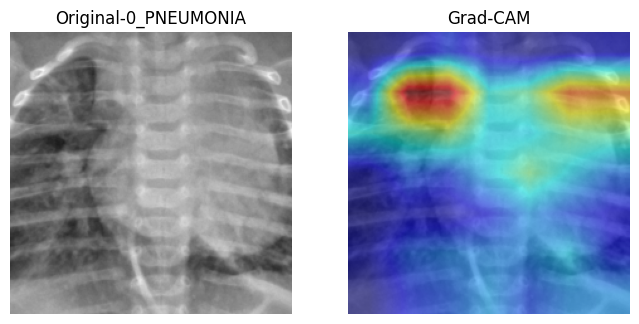

In [57]:
# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"Original-{classes[sample_label]}")
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(visualization)
plt.axis("off")
plt.show()

In [66]:
import io
import base64
from PIL import Image
import numpy as np

img_array = visualization
image_file = Image.fromarray((img_array * 255).astype(np.uint8)) if img_array.dtype == np.float32 else Image.fromarray(img_array)



In [68]:
type(image_file)

PIL.Image.Image

In [69]:
buffered = io.BytesIO()


In [75]:
image_file.save(buffered, format="PNG")
bs = base64.b64encode(buffered.getvalue()).decode("utf-8")

In [76]:
base64.b64decode(bs)

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe0\x00\x00\x00\xe0\x08\x02\x00\x00\x00\x95O\xfd\xb6\x00\x00\xeb\x9aIDATx\x9cl\xfd\xeb\x96\x1bI\x8f,\x88\x9a\x01\xf0\x08f\xaa\xbe\xbe\xcc\x9c\xf32\xf3j\xf3\xce\xb3\xbb\xbb$%\x19\xee\x80\xcd\x0fxPY\xfb\x9c\xacZZ)*\xc9$#\xe0\xb8\x18\x0c\x06\xfe_\xff\xd7\xff]UU%\x89$\x00\x92\xfdM\x7f\x0f@\xd2\xfb{\x92\x92\x00#\tXU\x01v?\xcb\xfb\x9f\x00T\xf5\xd3\xbd\xaa\xaa@\xf2~\x84\xef\xe7\xf6\x9f\x92$\xba\x87\xfb\x00\x048\xe9\xfd\xcb%3s\xc0\x01\x03\x08 \xb3_#H\'\xdd,\xdc\xdd,\x003\x0b\xd2\xe0\xa4S\x12(Q\xc5o\xdf\x00By\x84\x89\xe6\x9e\xd7Z3k\xf6\x8fP\t\x12(\xa0@\xc2\x0c\xfd\x17\xb2?\xbb\xcc`\x869_\xfd?)3\x02%\x95\x99\xa4\x8a \tw3\x83\xbb\xbb;\xc9\xcc\xb9\xd6"i\x86*\x91\x90\xb2\xaa\x00JIBR\xe6\x02 U\xd5\xaa*\x00f\xfb.\x90\x1a\xe3p7I\xa4\xfa\xab?\xf2\xfeg\xed\x1bT\x85\xbe\x92\x00\xb2\x7f\x03\x14\x11\x80K\x95\xa9\xb5VUI\xec+)Q\x12\xe9f}\xfb\xbc_\xbc\xef\x08\x00\xa0\xff\xb4\xfe[[\x84\xf4\xb6\rJ%\xa1M\xc3\x8c\xb7\x15\x99T$\xc96\x83$\x9d\xef\xb7.I0\xebw\xfe\xb6

In [77]:
# Decode the Base64 string
decoded_image_bytes = base64.b64decode(bs)

# Load the image from bytes
image_buffer = io.BytesIO(decoded_image_bytes)
image = Image.open(image_buffer)

# Display the image
image.show()

In [34]:
def save_grad_cam(model, image, label, save_dir):
    
    with GradCAM(model=model, target_layers=[model.model[0].model.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(sample_image.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
        outputs = cam.outputs
        
        pred = torch.argmax(outputs, dim=1)[0]
        title = ""
        if pred == label:
            if label == 0:
                title = "Correct-Pneumonia"
            else:
                title = "Correct-Normal"
        else:
            if label == 0:
                title = "Incorrect-False-Negative"
            else:
                title = "Incorrect-False-Positive"

        
        # Plot
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis("off")
        
        plt.subplot(1,2,2)
        plt.imshow(visualization)
        plt.axis("off")
        # plt.show()
        plt.suptitle(title)
        os.makedirs(save_dir, exist_ok=True)
        # plt.savefig(f"{save_dir}/{title}.png")

In [45]:
save_grad_cam(model, sample_image, sample_label, "grad-cam/correct-pneumonia")
save_grad_cam(model, sample_image, sample_label, "grad-cam/correct-pneumonia")

In [39]:
import time

In [41]:
time.time()

1758073594.8891578

In [46]:
a = torch.zeros(5)

In [48]:
b = torch.ones(5)

In [51]:
for i, [num1, num2] in enumerate(zip(a, b)):
    print(num1.item() == 0, num2.item())

True 1.0
True 1.0
True 1.0
True 1.0
True 1.0


In [43]:
grad_cam = {
    TRUE_POSITIVE: [],
    TRUE_NEGATIVE: [],
    FALSE_POSITIVE: [],
    FALSE_NEGATIVE: [],
}
met_count = 0
for step, (data, labels, original_images) in enumerate(test_loader):

        logits = model.forward(data)

        pred_labels = torch.argmax(logits, dim=1)


        for i, (label, pred_label) in enumerate(zip(labels, pred_labels)):
            label = label.item()
            pred_label = pred_label.item()
            pred_type = get_pred_type(label, pred_label)
            grad_cam[pred_type].append([data[i], label, original_images[i]])


In [38]:
for image, label, original_image in grad_cam["true-positive-pneumonia"]:
    print(np.max(original_image.permute(1, 2, 0).numpy()))

0.972549
0.67058825
0.8039216
0.72156864
0.7647059
0.72156864
0.75686276
0.81960785


In [21]:
type(image1)

torch.Tensor

In [23]:
np.max(image1.permute(1, 2, 0).numpy())

np.float32(0.972549)

In [44]:
torch.cuda.empty_cache()

In [46]:
from torchvision.models import resnet50, ResNet50_Weights
model1 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [48]:
for name, module in model1.named_modules():
    print(f"Name: {name}, Module: {module}")

Name: , Module: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1,

'123'